In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import joblib
from time import time
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
mul = pd.read_excel('2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx')
card = pd.read_csv('CARD_SPENDING_RESIDENT.txt', sep = "\t")

In [3]:
# 동 이름 삽입
cd = joblib.load('card_code_to_name_dict.pickle')
d_name = list(cd.items())[1][1]
g_name = list(cd.items())[0][1]

card['GU_DONG_CD'] = card['GU_CD'].astype('str')+card['DONG_CD'].astype('str')

gu_dong = pd.merge(pd.DataFrame(g_name.items()), pd.DataFrame(d_name.items()),on=0)
gu_dong['GU_DONG'] = gu_dong[['1_x','1_y']].apply(lambda x: ','.join(x), axis=1)
gu_dong = gu_dong.rename(columns={0: 'GU_DONG_CD'})[['GU_DONG_CD','GU_DONG']]

In [4]:
card = pd.merge(card,gu_dong,on='GU_DONG_CD')

In [5]:
card['DATE'] = card['STD_DD'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
mul['DATE'] = mul['DL_YMD'].apply(lambda x: pd.to_datetime(str(x), format='%y%m%d'))

In [6]:
food = mul.query('DL_GD_LCLS_CD == 17').groupby(['DATE'])['INVC_CONT'].sum().reset_index()
#food['food_roll'] = food.rolling(window=3, min_periods=1).mean()

In [7]:
## 외식업종 건당 구매금액
out_eat = card.query('MCT_CAT_CD == 80').groupby(['DATE'])[['USE_AMT','USE_CNT']].mean().reset_index()
out_eat['out_eat_per'] = card['USE_AMT'] / card['USE_CNT']
#out_eat['out_eat_per_roll'] = out_eat['out_eat_per'].rolling(window=3, min_periods=1).mean()
#out_eat['out_eat_roll'] = out_eat[['DATE','USE_AMT']].rolling(window=3, min_periods=1).mean()

In [8]:
out_eat['YEAR'] = out_eat['DATE'].dt.year.astype('str')
out_eat['MONTH'] = out_eat['DATE'].dt.month.astype('str')
out_eat['DAY'] = out_eat['DATE'].dt.day.astype('str')
out_eat['MD'] = out_eat[['MONTH','DAY']].apply(lambda x: '-'.join(x), axis=1)
out_eat['WEEKDAY'] = out_eat['DATE'].dt.weekday

food['WEEKDAY'] = food['DATE'].dt.weekday

In [9]:
food['WEEKEND'] = np.where(food['WEEKDAY'] > 4, 1, 0)
out_eat['WEEKEND'] = np.where(out_eat['WEEKDAY'] > 4, 1, 0)
food['YEAR'] = food['DATE'].dt.year

In [26]:
## 평일 이용내역 확인
food_h = food.query('WEEKEND == 0').reset_index()
out_eat_h = out_eat.query('WEEKEND == 0').reset_index()
food_h_2019 = food.query('(WEEKEND == 0) and (YEAR == 2019)').reset_index()
food_h_2020 = food.query('(WEEKEND == 0) and (YEAR == 2020)').reset_index()
out_eat_h_2019 = out_eat.query('(WEEKEND == 0) and (YEAR == "2019")').reset_index()
out_eat_h_2020 = out_eat.query('(WEEKEND == 0) and (YEAR == "2020")').reset_index()

In [27]:
## 가중이동평균 구하기
def weightedMean(weightArray):
    def inner(x):
        return (weightArray * x).mean()
    return inner

n = 3
t = [v for v in np.arange(1, n+1)]
sumv = sum(t) / n
wts = np.array(t) / sumv
food_h['food_roll'] = food_h['INVC_CONT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h['out_eat_per_roll'] = out_eat_h['out_eat_per'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h['out_eat_roll'] = out_eat_h['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0) #USE_CNT의 경우
food_h_2019['food_roll'] = food_h_2019['INVC_CONT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
food_h_2020['food_roll'] = food_h_2020['INVC_CONT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h_2019['out_eat_per_roll'] = out_eat_h_2019['out_eat_per'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h_2019['out_eat_roll'] = out_eat_h_2019['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0) #USE_CNT의 경우
out_eat_h_2020['out_eat_per_roll'] = out_eat_h_2020['out_eat_per'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h_2020['out_eat_roll'] = out_eat_h_2020['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0) #USE_CNT의 경우

In [15]:
food_h_2019 = food_h_2019.query('food_roll != 0')
food_h_2020 = food_h_2020.query('food_roll != 0')
out_eat_h_2019 = out_eat_h_2019.query('out_eat_roll != 0')
out_eat_h_2020 = out_eat_h_2020.query('out_eat_roll != 0')

In [32]:
food

,DATE,INVC_CONT,WEEKDAY,WEEKEND,YEAR
0,2019-02-01,1336,4,0,2019
1,2019-02-02,109,5,1,2019
2,2019-02-03,157,6,1,2019
3,2019-02-04,12,0,0,2019
4,2019-02-05,21,1,0,2019
...,...,...,...,...,...
236,2020-05-27,23622,2,0,2020
237,2020-05-28,22348,3,0,2020
238,2020-05-29,19415,4,0,2020
239,2020-05-30,1335,5,1,2020


In [34]:
pd.merge(out_eat_h_2019[['DATE','out_eat_roll','out_eat_per_roll']], food_h_2019[['DATE','food_roll']], on='DATE').corr()

,out_eat_roll,out_eat_per_roll,food_roll
out_eat_roll,1.000000,0.164809,0.613390
out_eat_per_roll,0.164809,1.000000,0.055877
food_roll,0.613390,0.055877,1.000000


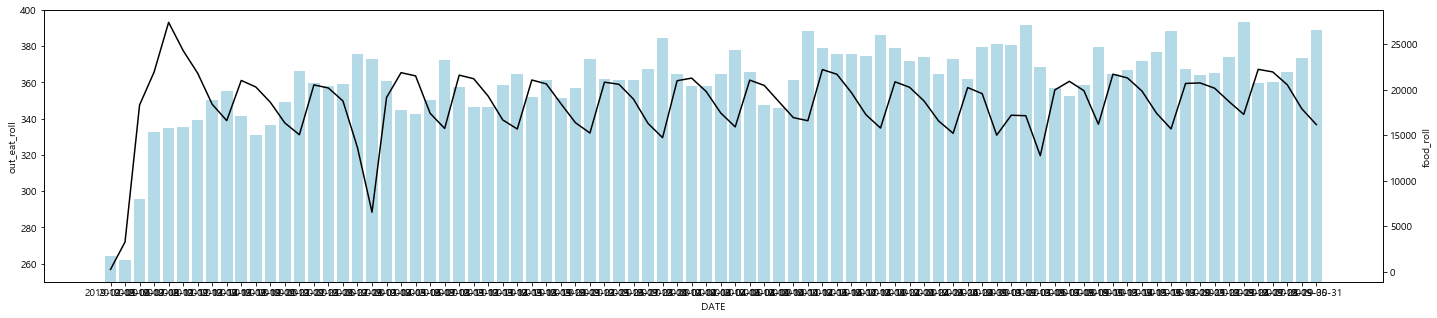

In [21]:
out_eat_h_2019['DATE'] = out_eat_h_2019['DATE'].astype('str')
food_h_2019['DATE'] = food_h_2019['DATE'].astype('str')

fig, ax = plt.subplots(figsize=(24,5))
sns.barplot(data = out_eat_h_2019, x = 'DATE', y = 'out_eat_roll',alpha = 0.7, color = 'skyblue', ax = ax)
ax.set_ylim(250, 400)

g = ax.twinx()
g = sns.lineplot(data = food_h_2019, x = 'DATE', y = 'food_roll', color = 'k')

In [23]:
pd.merge(out_eat_h_2020[['DATE','out_eat_roll','out_eat_per_roll']], food_h_2020[['DATE','food_roll']], on='DATE').corr()

,out_eat_roll,out_eat_per_roll,food_roll
out_eat_roll,1.000000,0.043530,-0.546015
out_eat_per_roll,0.043530,1.000000,-0.198668
food_roll,-0.546015,-0.198668,1.000000


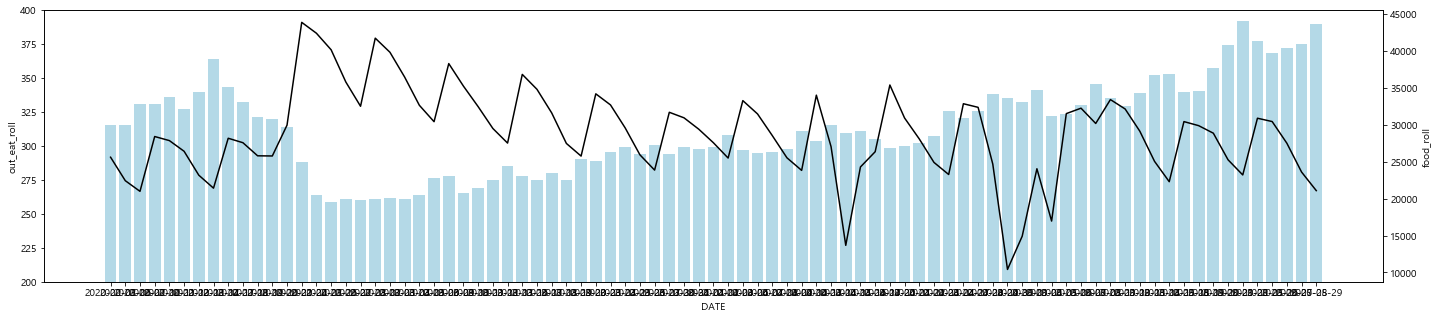

In [24]:
out_eat_h_2020['DATE'] = out_eat_h_2020['DATE'].astype('str')
food_h_2020['DATE'] = food_h_2020['DATE'].astype('str')

fig, ax = plt.subplots(figsize=(24,5))
sns.barplot(data = out_eat_h_2020, x = 'DATE', y = 'out_eat_roll',alpha = 0.7, color = 'skyblue', ax = ax)
ax.set_ylim(200, 400)

g = ax.twinx()
g = sns.lineplot(data = food_h_2020, x = 'DATE', y = 'food_roll', color = 'k')

In [25]:
pd.merge(out_eat_h[['DATE','out_eat_roll','out_eat_per_roll']], food_h[['DATE','food_roll']], on='DATE').corr()

,out_eat_roll,out_eat_per_roll,food_roll
out_eat_roll,1.000000,0.009825,-0.184500
out_eat_per_roll,0.009825,1.000000,0.005254
food_roll,-0.184500,0.005254,1.000000


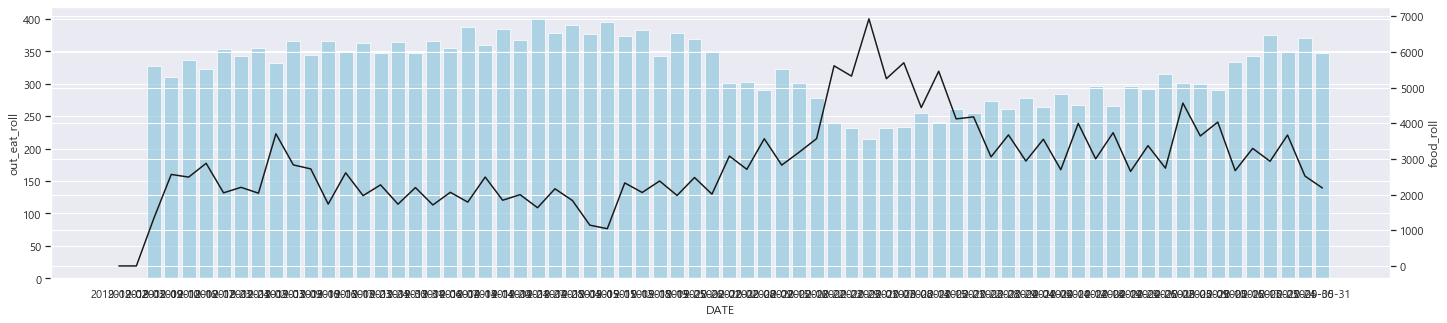

In [231]:
out_eat_h['DATE'] = out_eat_h['DATE'].astype('str')
food_h['DATE'] = food_h['DATE'].astype('str')

fig, ax = plt.subplots(figsize=(24,5))
sns.barplot(data = out_eat_h, x = 'DATE', y = 'out_eat_roll',alpha = 0.7, color = 'skyblue', ax = ax)
#ax.set_ylim(200, 400)

g = ax.twinx()
g = sns.lineplot(data = food_h, x = 'DATE', y = 'food_roll', color = 'k')

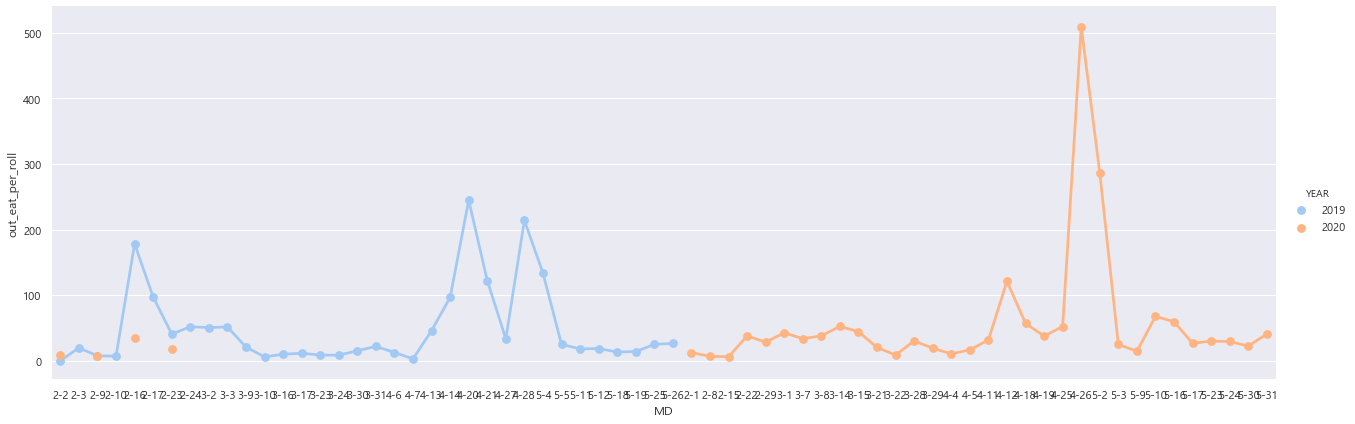

In [155]:
sns.factorplot(data=out_eat_h, x='MD', y='out_eat_per_roll',hue='YEAR',size=6,aspect=3)